In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df_previous = pd.read_table("cat_df_fitness_2.selected.txt")
df_recent = pd.read_table("recent_df_fintess_selected.txt")
df_recent.insert(4, 'data_class', 'recent')

In [3]:
df = pd.concat([df_previous, df_recent], ignore_index=True) # the lengths of all seqs are equal (MSA)
df

,hap_Id,country,outcome,clade,data_class,seq,haplotype
0,hap_340105,USA,0.168650,20C,train,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,"S:T299I, S:D614G"
1,hap_50585,USA,0.511103,21K,train,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,"S:H66R, S:A67V, S:T95I, S:Y145D, S:L212I, S:G3..."
2,hap_78343,USA,0.251574,21F,train,MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,"S:L5F, S:T95I, S:D253G, S:E484K, S:D614G, S:Q6..."
3,hap_98598,USA,0.191863,21C,train,MFVFLVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,"S:S13I, S:W152C, S:D614G"
4,hap_85192,USA,0.238975,20I,train,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,"S:N501Y, S:A570D, S:D614G, S:P681H, S:T716I, S..."
...,...,...,...,...,...,...,...
21509,hap_251948,USA,0.741129,22B,recent,MFVFLVLLPLVSSQCVNLLTRTQ---SYTNSFTRGVYYPDKVFRSS...,"S:T19L, S:A27S, S:G142D, S:V213G, S:G339D, S:R..."
21510,hap_215284,Australia,0.875143,23B,recent,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,"S:T19I, S:A27S, S:V83A, S:G142D, S:H146Q, S:E1..."
21511,hap_124106,Netherlands,0.759920,22B,recent,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,"S:T19I, S:A27S, S:G142D, S:K150E, S:V213G, S:G..."
21512,hap_140671,Germany,0.741072,22E,recent,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,"S:T19I, S:A27S, S:G142D, S:V213G, S:G339D, S:R..."


In [4]:
rows_with_nan = df[df.isna().any(axis=1)]

if not rows_with_nan.empty:
    print("Rows containing NaN values：")
    print(rows_with_nan)
else:
    print("Rows that do not contain a NaN value")

# All sequences with nan value are original variant, and have the same sequence

Rows containing NaN values：
      hap_Id      country   outcome clade data_class  \
157    hap_1        Japan  0.113551   19A      train   
3971   hap_1      Denmark -0.006154   19A      train   
4001   hap_1        Italy  0.228098   19A      train   
4366   hap_1      Germany  0.230058   19A      train   
5211   hap_1       France  0.221117   19A      train   
5864   hap_1       Brazil  0.474425   19A      train   
7266   hap_1  Switzerland  0.149540   19A      train   
8186   hap_1      Belgium  0.174145   19A      train   
9479   hap_1        Spain  0.282715   19A      train   
10614  hap_1       Sweden  0.109842   19A      train   
11894  hap_1        India  0.336769   19A      train   
12335  hap_1  Netherlands  0.093008   19A      train   
13088  hap_1           UK -0.018729   19A      train   
13379  hap_1  South Korea  0.201690   19A      train   
14101  hap_1    Australia  0.146408   19A      train   
15992  hap_1       Canada  0.172070   19A       test   
17752  hap_1        

In [5]:
haplotypes = df["haplotype"]
all_haplotypes = []

# Add the haplotype of each variant separately to the list all_haplotypes
for i in range(len(haplotypes)):
    if pd.notna(haplotypes[i]): # For variants other than 19A
        haplotype = haplotypes[i].split(", ")
        all_haplotypes.append(haplotype)
    else: # For variant 19A
        all_haplotypes.append(["nan"])

In [6]:
flat_haplotype = [item for sublist in all_haplotypes for item in sublist] # Turn multi-dimensional all_haplotypes to one-dimensioanl
substitutions = set(flat_haplotype) # Identify all substitutions without repetition
substitutions = list(substitutions)

In [7]:
# Construct the substitution matrix, columns are the name of substitutions, rows are different variants, 1 means the substitution happend.
substitution_matrix = np.zeros((len(all_haplotypes), len(substitutions)))
                              
for i in range(len(substitutions)):
    for j in range(len(all_haplotypes)):
        if substitutions[i] in all_haplotypes[j]:
            substitution_matrix[j][i] = 1

In [8]:
df_substitution = pd.DataFrame(substitution_matrix, columns=substitutions, index=list(df["clade"]))
df_substitution["country"] = list(df["country"])
onehot_country = pd.get_dummies(df_substitution["country"]) # One-hot Encoding of country names
df_substitution = pd.concat([df_substitution, onehot_country], axis=1)
del df_substitution["country"]
df_substitution["data_class"] = list(df["data_class"])
df_substitution["outcome"] = list(df["outcome"])

del df_substitution["nan"]

In [9]:
df_substitution

,S:T299I,S:A846V,S:T724I,S:D53E,S:V534I,S:L1049I,S:T716V,S:D1084A,S:C136-,S:E619Q,...,Japan,Netherlands,South Korea,Spain,Sweden,Switzerland,UK,USA,data_class,outcome
20C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,train,0.168650
21K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,train,0.511103
21F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,train,0.251574
21C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,train,0.191863
20I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,train,0.238975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,recent,0.741129
23B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,recent,0.875143
22B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,recent,0.759920
22E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,recent,0.741072


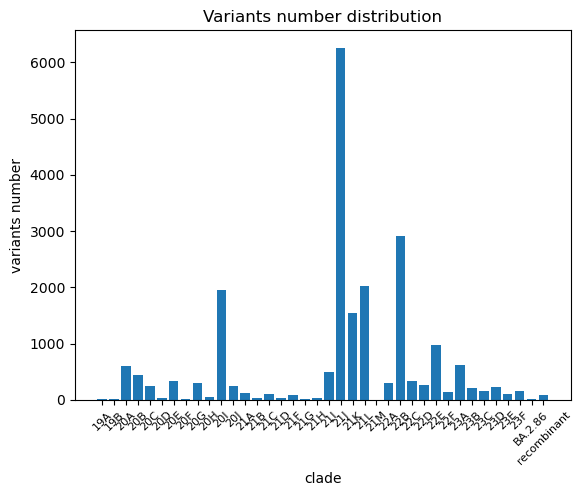

In [10]:
counts = df_substitution.index.value_counts().sort_index()
plt.bar(counts.index,counts.values)
plt.xticks(fontsize=8, rotation=45)
plt.title("Variants number distribution")
plt.xlabel("clade")
plt.ylabel("variants number")
plt.show()

In [11]:
train_df = df_substitution[df_substitution['data_class'] == 'train']
test_df = df_substitution[df_substitution['data_class'] == 'test']
recent_df = df_substitution[df_substitution['data_class'] == 'recent']
test_plus_recent_df = pd.concat([test_df, recent_df]) # Concate the test set in the previous dataset and the recent dataset to get a whole test set

# Labels and features of training set
train_labels = train_df["outcome"]
train_features = train_df.drop(["outcome","data_class"], axis=1)
# Labels and features of old test set
test_labels = test_df["outcome"]
test_features = test_df.drop(["outcome","data_class"], axis=1)
# Labels and features of recent set
recent_labels = recent_df["outcome"]
recent_features = recent_df.drop(["outcome","data_class"], axis=1)
# Labels and features of whole test set
test_plus_recent_labels = test_plus_recent_df["outcome"]
test_plus_recent_features = test_plus_recent_df.drop(["outcome","data_class"], axis=1)

print(train_features.shape)
print(test_features.shape)
print(recent_features.shape)
print(test_plus_recent_features.shape)

(14576, 2223)
(3634, 2223)
(3304, 2223)
(6938, 2223)


# Feature Selection

In [12]:
# Use random Forest to do feature selection
rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
rf.fit(train_features, train_labels)
    
importances = list(rf.feature_importances_) # Obtain the list of importance of each feature
feature_list = list(train_features.columns) # Obtain the list of features
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)] # Get (feature, importance) tuple
feature_importances = sorted(feature_importances, key= lambda x: x[1], reverse = True) # Rank features according to importance
    
selected_features = feature_importances[:200] # Select most important 200 features in the format of (feature, importance) tuple

for i in range(len(selected_features)):
    selected_features[i] = list(selected_features[i])[0] # Convert (feature, importance) tuple into feature name
    
print(selected_features)

['S:N969K', 'UK', 'S:Q493R', 'S:P681R', 'S:Q954H', 'Denmark', 'USA', 'S:N501Y', 'S:G496S', 'S:N856K', 'Brazil', 'S:L981F', 'S:T478K', 'S:F486V', 'S:A67V', 'Spain', 'S:P681H', 'India', 'Canada', 'S:L452Q', 'S:R346T', 'Germany', 'Netherlands', 'Japan', 'S:E484K', 'S:L452R', 'S:R346K', 'S:G142-', 'S:T95I', 'S:G142D', 'Italy', 'S:D950N', 'S:V143-', 'Switzerland', 'France', 'S:Y145H', 'S:A222V', 'Sweden', 'S:T19R', 'S:N460K', 'S:T859N', 'S:K417N', 'S:V3G', 'S:N211-', 'S:N440K', 'S:K417T', 'S:E156-', 'S:F157-', 'South Korea', 'S:Y505H', 'Belgium', 'S:N658S', 'S:W152R', 'S:V70-', 'S:D614G', 'S:L452M', 'S:S477N', 'S:Q677H', 'S:H69-', 'S:214:EPE', 'S:R158G', 'S:L18F', 'S:Q498R', 'S:T76I', 'S:S371F', 'S:N450D', 'Australia', 'S:N764K', 'S:Y144-', 'S:T376A', 'S:R408S', 'S:V213G', 'S:Y248N', 'S:L5F', 'S:A1020S', 'S:R346S', 'S:V1264L', 'S:T716I', 'S:Q675H', 'S:I68T', 'S:A27S', 'S:Y248S', 'S:Q613H', 'S:L24S', 'S:T732A', 'S:V1176F', 'S:E702K', 'S:M153I', 'S:E484A', 'S:H655Y', 'S:W64R', 'S:V1104L', 'S:

In [13]:
feature_importances[0:10]

[('S:N969K', 0.7302819999),
 ('UK', 0.0524521141),
 ('S:Q493R', 0.0506394271),
 ('S:P681R', 0.0471690933),
 ('S:Q954H', 0.0385294129),
 ('Denmark', 0.0140977501),
 ('USA', 0.009836022),
 ('S:N501Y', 0.0065312613),
 ('S:G496S', 0.005360796),
 ('S:N856K', 0.0051222981)]

In [14]:
# Only use selected features for further training
train_features = train_features[selected_features]
test_features = test_features[selected_features]
recent_features = recent_features[selected_features]
test_plus_recent_features = test_plus_recent_features[selected_features]

In [15]:
train_features

,S:N969K,UK,S:Q493R,S:P681R,S:Q954H,Denmark,USA,S:N501Y,S:G496S,S:N856K,...,S:N1192S,S:F157L,S:M153T,S:I584V,S:Q613E,S:A879V,S:E1150D,S:V1177I,S:G1219C,S:I1081V
20C,0.0,0,0.0,0.0,0.0,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21K,1.0,0,1.0,0.0,1.0,0,1,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21F,0.0,0,0.0,0.0,0.0,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21C,0.0,0,0.0,0.0,0.0,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20I,0.0,0,0.0,0.0,0.0,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20E,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20A,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22D,1.0,1,0.0,0.0,1.0,0,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21L,1.0,0,1.0,0.0,1.0,1,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Random Forest

In [16]:
# Define the parameter space for random forest
param_space = {
    'n_estimators': Integer(200, 2000),
    'max_depth': Categorical([10, 20, 30, None]),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'min_samples_split': Integer(2, 20), 
    'min_samples_leaf': Integer(1, 4),
    'bootstrap': Categorical([True, False])
    }

rf1 = RandomForestRegressor(random_state=42)
# Create a Bayesian search object
bayes_search = BayesSearchCV(
    rf1,
    param_space,
    n_iter=20, # Number of iteration times
    scoring='r2',  # Metric to optimize
    n_jobs=-1,  # Number of jobs to run in parallel
    random_state=42
    )

# Fit the Bayesian search object to the data
bayes_search.fit(train_features, train_labels)
# Print the best score and best parameters
print(bayes_search.best_score_)
print(bayes_search.best_params_)
    
best_params = bayes_search.best_params_
rf1 = RandomForestRegressor(**best_params)      
rf1.fit(train_features, train_labels)

# Create predicted fitness dataframe
predictions = rf1.predict(test_plus_recent_features)
prediction_df_rf = test_plus_recent_features.copy()
prediction_df_rf["outcome"] = test_plus_recent_labels
prediction_df_rf["predicted_outcome"] = predictions
prediction_df_rf["data_class"] = test_plus_recent_df["data_class"]

0.9915776229986074
OrderedDict([('bootstrap', True), ('max_depth', 30), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 330)])


In [17]:
test_recent_df_rf = df[df['data_class'].isin(['test', 'recent'])].reset_index(drop=True)
test_recent_df_rf["predicted_outcome"] = predictions
file_name = 'cat_df_fitness_2_prediction_rf.csv'
test_recent_df_rf.to_csv(file_name, index=False)

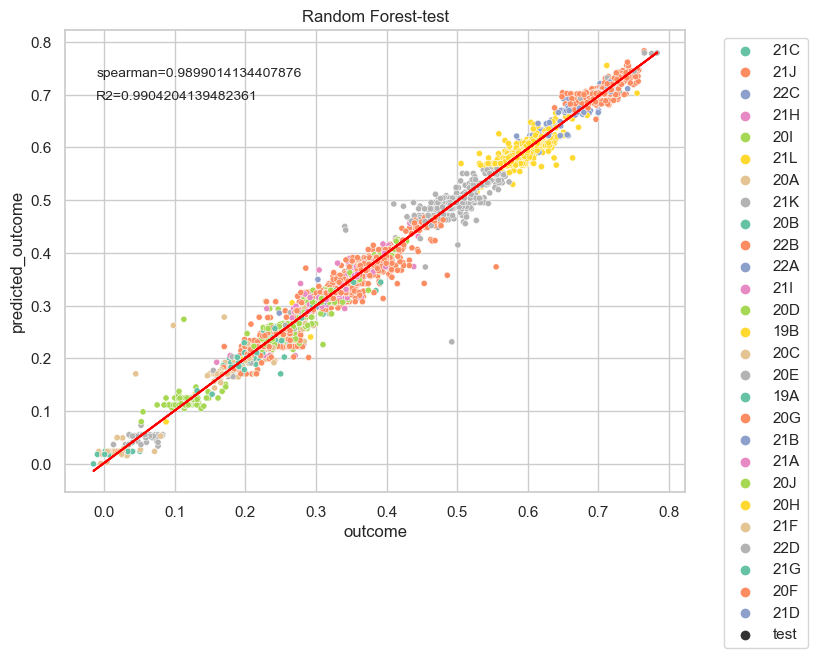

In [18]:
prediction_df_test = prediction_df_rf[prediction_df_rf['data_class'] == "test"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_test, y='predicted_outcome', x='outcome', hue=prediction_df_test.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_test["outcome"], prediction_df_test["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_test["outcome"].corr(prediction_df_test["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("Random Forest-test")

# Plot fit curve by using linear regression
labels = prediction_df_test["outcome"].tolist()
predictions = prediction_df_test["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

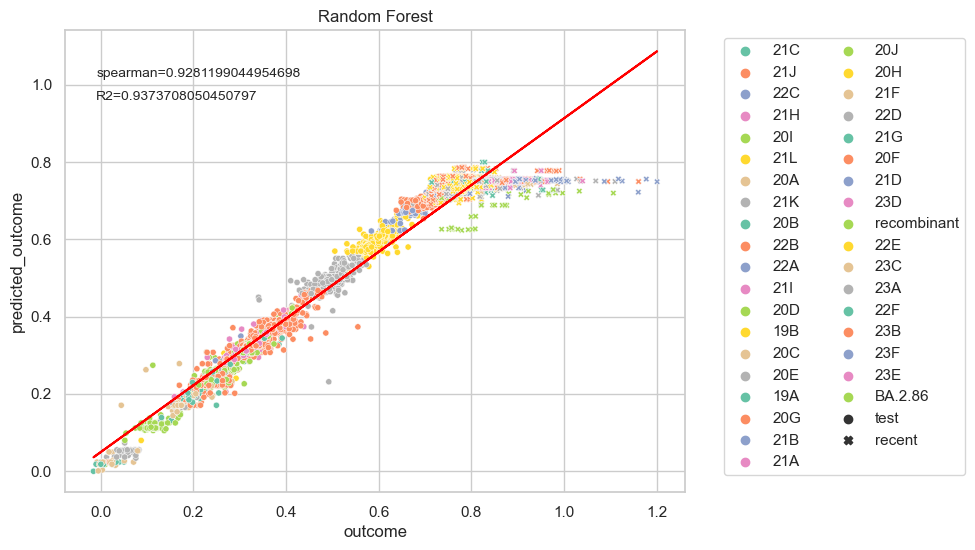

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_rf, y='predicted_outcome', x='outcome', hue=prediction_df_rf.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

r2 = r2_score(prediction_df_rf["outcome"], prediction_df_rf["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_rf["outcome"].corr(prediction_df_rf["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("Random Forest")

# Plot fit curve by using linear regression
labels = prediction_df_rf["outcome"].tolist()
predictions = prediction_df_rf["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

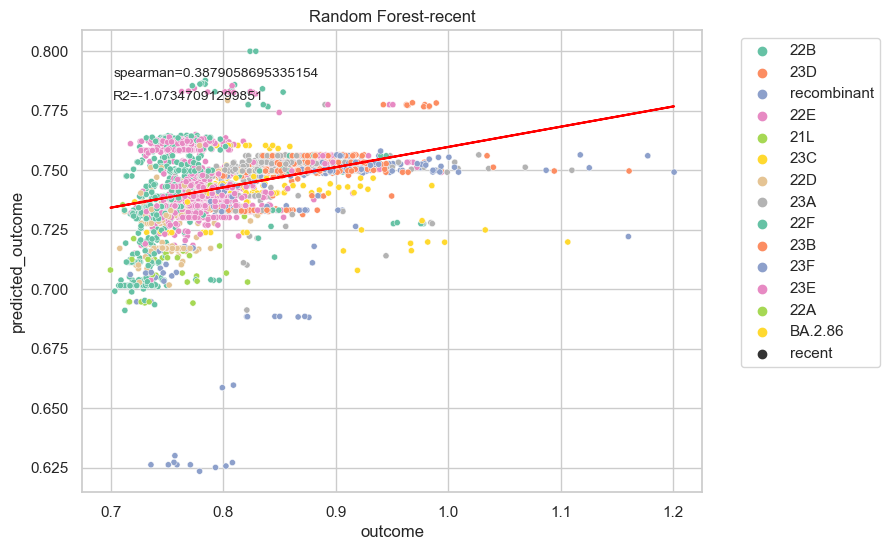

In [20]:
prediction_df_recent = prediction_df_rf[prediction_df_rf['data_class'] == "recent"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_recent, y='predicted_outcome', x='outcome', hue=prediction_df_recent.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_recent["outcome"], prediction_df_recent["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("Random Forest-recent")

# Plot fit curve by using linear regression
labels = prediction_df_recent["outcome"].tolist()
predictions = prediction_df_recent["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

# LASSO

In [21]:
param_space = {
    'alpha': Real(1e-7, 1e-4, prior="log-uniform"),
    'max_iter': Integer(10000, 12000),
    'tol': Real(1e-7, 1e-5, prior="log-uniform"),
    'selection': Categorical(["cyclic", "random"])
    }

lasso = linear_model.Lasso()
# Create a Bayesian search object
bayes_search = BayesSearchCV(
        lasso,
        param_space,
        n_iter=20,  # Number of parameter settings that are sampled
        scoring='r2',  # Metric to optimize
        n_jobs=-1,  # Number of jobs to run in parallel
        random_state=42
    )
# Fit the Bayesian search object to the data
bayes_search.fit(train_features, train_labels)
# Print the best score and best parameters
print(bayes_search.best_score_)
print(bayes_search.best_params_)
    
best_params = bayes_search.best_params_
lasso = linear_model.Lasso(**best_params)
       
lasso.fit(train_features, train_labels)
predictions = lasso.predict(test_plus_recent_features)

prediction_df_lasso = test_plus_recent_features.copy()
prediction_df_lasso["outcome"] = test_plus_recent_labels
prediction_df_lasso["predicted_outcome"] = predictions
prediction_df_lasso["data_class"] = test_plus_recent_df["data_class"]

0.9660211043431856
OrderedDict([('alpha', 1.0236890738668676e-05), ('max_iter', 10042), ('selection', 'random'), ('tol', 1.60353471639732e-07)])


In [22]:
test_recent_df_lasso = df[df['data_class'].isin(['test', 'recent'])].reset_index(drop=True)
test_recent_df_lasso["predicted_outcome"] = predictions
file_name = 'cat_df_fitness_2_prediction_lasso.csv'
test_recent_df_lasso.to_csv(file_name, index=False)

0.9829072956335039


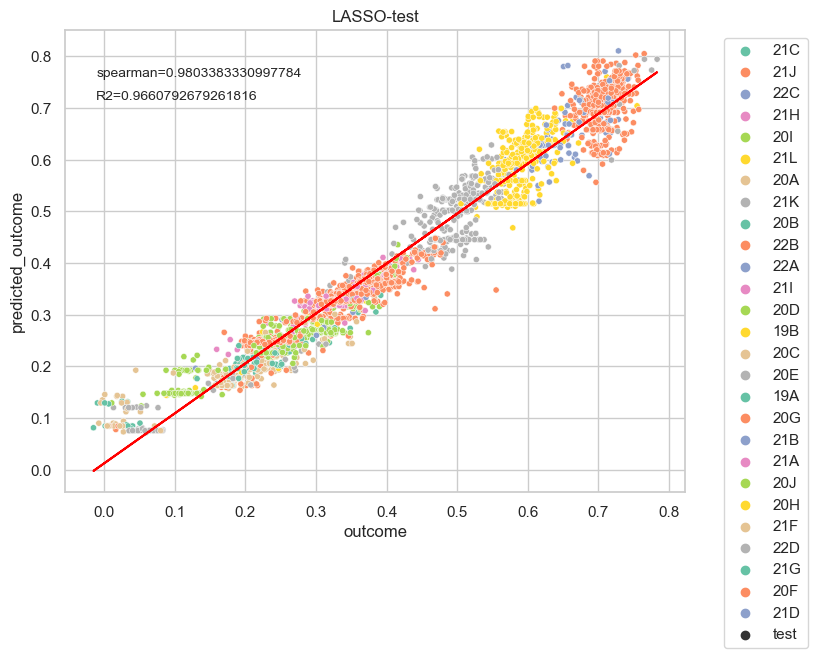

In [23]:
prediction_df_test = prediction_df_lasso[prediction_df_lasso['data_class'] == "test"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_test, y='predicted_outcome', x='outcome', hue=prediction_df_test.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_test["outcome"], prediction_df_test["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
corr=prediction_df_test["outcome"].corr(prediction_df_test["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(corr), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)

plt.title("LASSO-test")
print(prediction_df_test["outcome"].corr(prediction_df_test["predicted_outcome"]))

labels = prediction_df_test["outcome"].tolist()
predictions = prediction_df_test["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

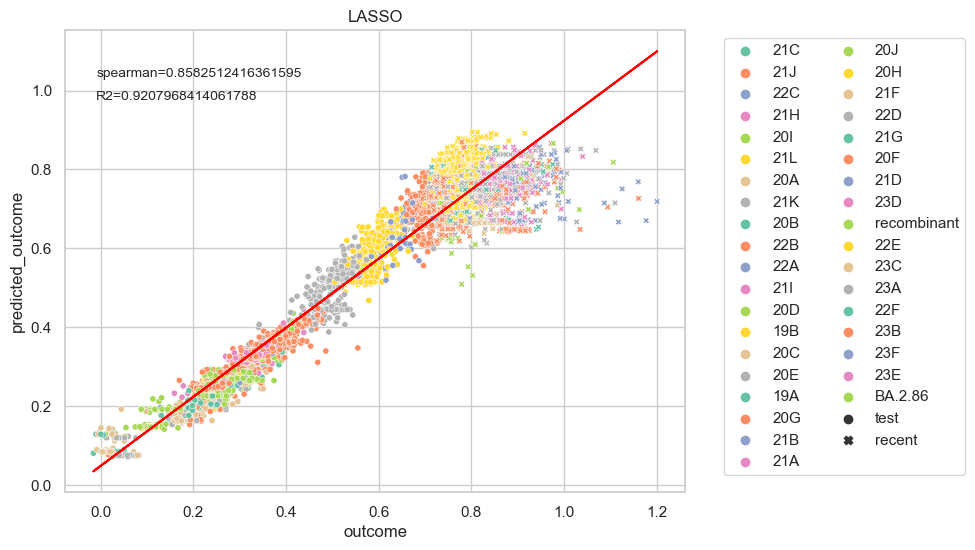

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_lasso, y='predicted_outcome', x='outcome', hue=prediction_df_lasso.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

r2 = r2_score(prediction_df_lasso["outcome"], prediction_df_lasso["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_lasso["outcome"].corr(prediction_df_lasso["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LASSO")

labels = prediction_df_lasso["outcome"].tolist()
predictions = prediction_df_lasso["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

-0.03056580592896304


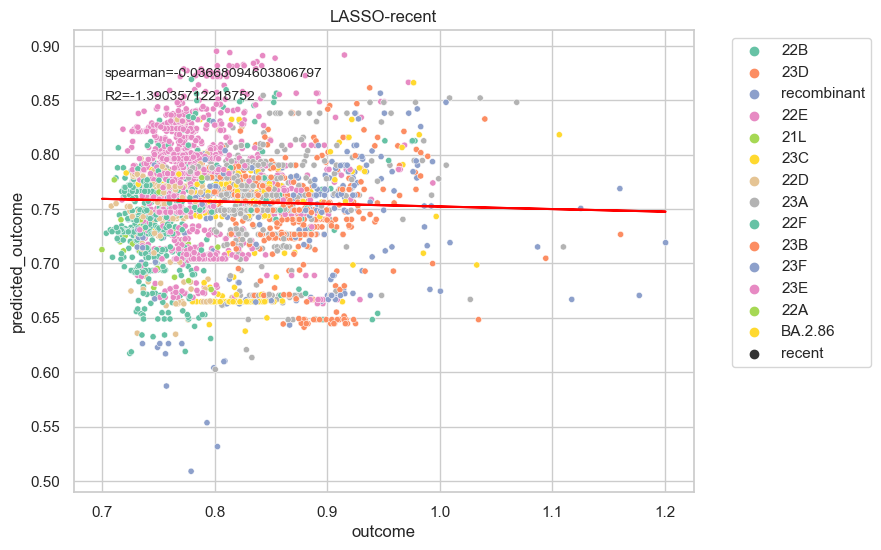

In [25]:
prediction_df_recent = prediction_df_lasso[prediction_df_lasso['data_class'] == "recent"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_recent, y='predicted_outcome', x='outcome', hue=prediction_df_recent.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_recent["outcome"], prediction_df_recent["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
corr=prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(corr), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)

plt.title("LASSO-recent")
print(prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"]))

labels = prediction_df_recent["outcome"].tolist()
predictions = prediction_df_recent["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

# LightGBM

In [26]:
# Use Bayes search to do finetuning
train_features_nd = np.array(train_features)
test_plus_recent_features_nd = np.array(test_plus_recent_features)

param_space = {
    'max_depth': Integer(30, 50),
    'learning_rate': Real(0.1, 0.4),
    'n_estimators': Integer(500, 1000),
    'min_child_weight': Integer(1, 10),
    'reg_alpha': Real(1e-6, 1e-4),
    'num_leaves': Integer(20, 50),
    'reg_lambda': Real(0, 10)    
    }

lgbr = LGBMRegressor()
# Create a Bayesian search object
opt = BayesSearchCV(
    lgbr,
    param_space,
    n_iter=20,  # Number of iteration times
    scoring='r2',  # Metric to optimize
    n_jobs=-1,  # Number of jobs to run in parallel
    random_state=42
    )
# Fit the Bayesian search object to the data
opt.fit(train_features_nd, train_labels)
# Print the best score and best parameters
print(opt.best_score_)
print(opt.best_params_)
    
best_params = opt.best_params_
lgbr = LGBMRegressor(**best_params)
       
lgbr.fit(train_features_nd, train_labels)
predictions = lgbr.predict(test_plus_recent_features_nd)

prediction_df_lgb = test_plus_recent_features.copy()
prediction_df_lgb["outcome"] = test_plus_recent_labels
prediction_df_lgb["predicted_outcome"] = predictions
prediction_df_lgb["data_class"] = test_plus_recent_df["data_class"]

0.9922154205671262
OrderedDict([('learning_rate', 0.18677776917692213), ('max_depth', 32), ('min_child_weight', 5), ('n_estimators', 1000), ('num_leaves', 32), ('reg_alpha', 0.0001), ('reg_lambda', 1.512575687373527)])


In [27]:
test_recent_df_lgb = df[df['data_class'].isin(['test', 'recent'])].reset_index(drop=True)
test_recent_df_lgb["predicted_outcome"] = predictions
file_name = 'cat_df_fitness_2_prediction_lgb.csv'
test_recent_df_lgb.to_csv(file_name, index=False)

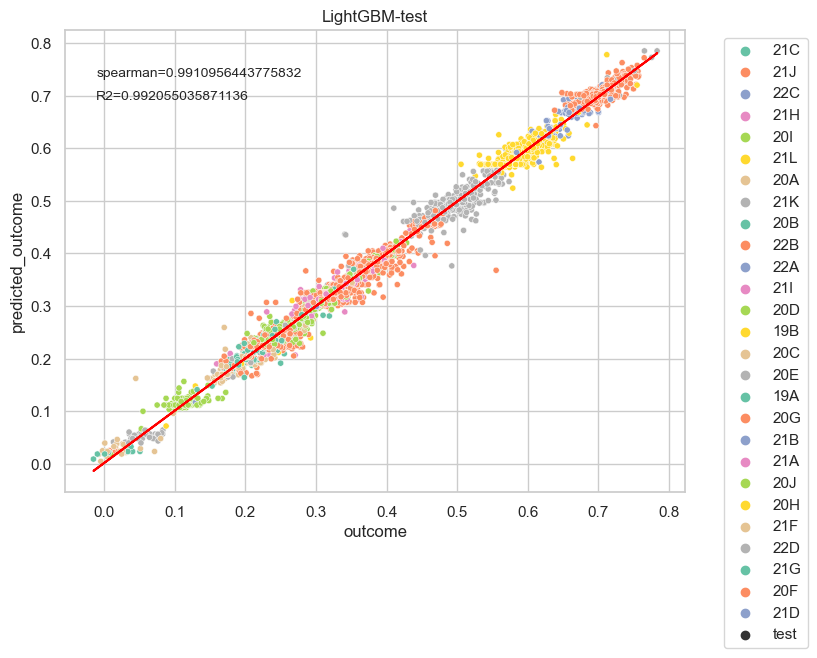

In [28]:
prediction_df_test = prediction_df_lgb[prediction_df_lgb['data_class'] == "test"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_test, y='predicted_outcome', x='outcome', hue=prediction_df_test.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_test["outcome"], prediction_df_test["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_test["outcome"].corr(prediction_df_test["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LightGBM-test")

labels = prediction_df_test["outcome"].tolist()
predictions = prediction_df_test["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

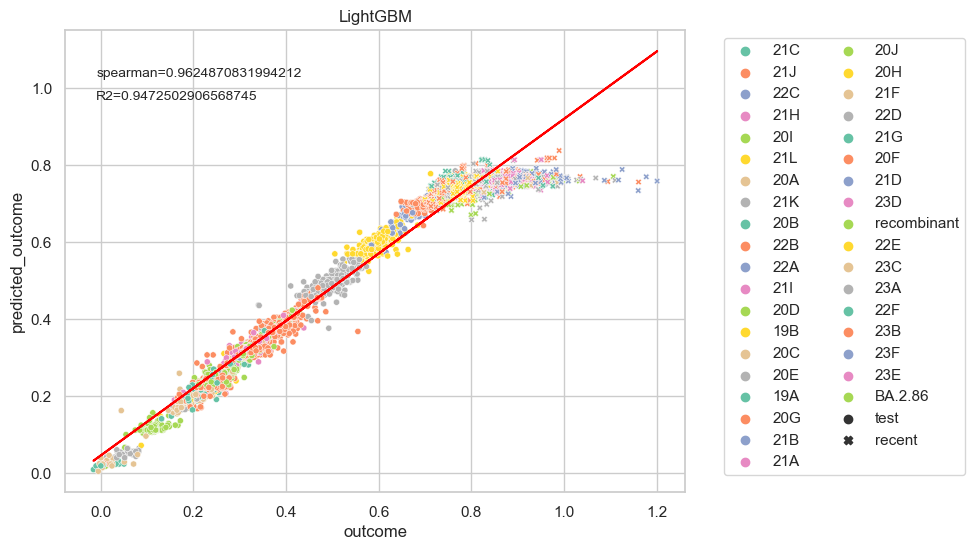

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_lgb, y='predicted_outcome', x='outcome', hue=prediction_df_lgb.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

r2 = r2_score(prediction_df_lgb["outcome"], prediction_df_lgb["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_lgb["outcome"].corr(prediction_df_lgb["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LightGBM")

labels = prediction_df_lgb["outcome"].tolist()
predictions = prediction_df_lgb["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]

plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

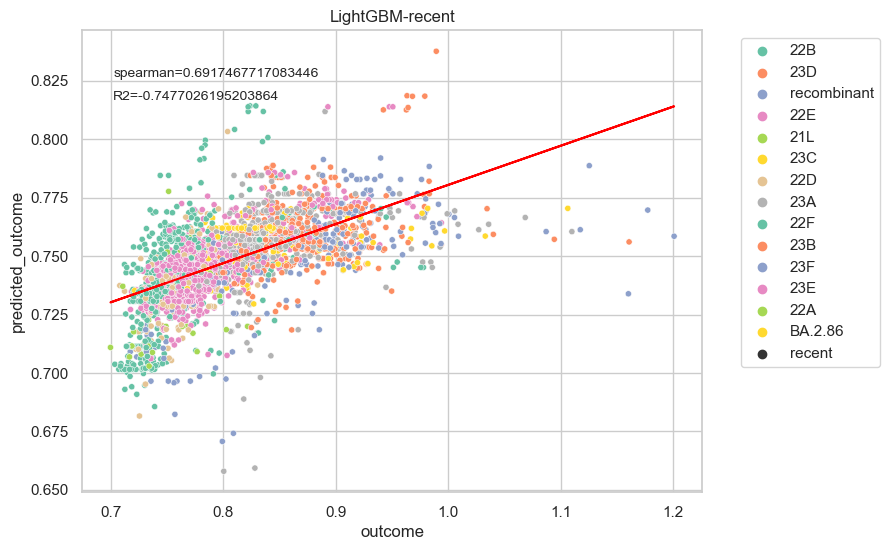

In [30]:
prediction_df_recent = prediction_df_lgb[prediction_df_lgb['data_class'] == "recent"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_recent, y='predicted_outcome', x='outcome', hue=prediction_df_recent.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_recent["outcome"], prediction_df_recent["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LightGBM-recent")

labels = prediction_df_recent["outcome"].tolist()
predictions = prediction_df_recent["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()